# Setup

In [2]:
import sys
import os

import re
import collections
import itertools
import bcolz
import pickle

import numpy as np
import pandas as pd
import gc
import random
import smart_open
import h5py
import csv

import tensorflow as tf
import gensim
import string

import datetime as dt
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
import seaborn as sns

random_state_number = 967898

# Code

## Day 1: Inverse Captcha

In [2]:
! cat day1_input.txt

3181317434923597215981186975516634388295837647427843768163249522249921148864954375565513884255386724613124546288175686273692292575264734167334275651485666397949674715824179285762547132353518322249794975164448827731717349612447389345242511813364598448875912889714649883137379572166169649262227628288121837127397353816377978243521149119661637513547251793548196443995684453613682375776449496729725154538946447279447444794156477873392653274175275786524394697626642654834188987351438346414265942512278666739914333577217497312838386989332597731965183951669429553414666872882239345262632189235719257444485626472158536516494564725464526469395789837321489784842496626658299127249677115958371545671464558557664145835832652185851831931523385747369571223832378725455659756646118845227985376618433369634439581861521584634858654116419462437135355681254894544743278779548944331294168722131443269411584786312982653262822838689468339235279951494266539627372682193634666348549915914136844378247571467995321338837593951

In [18]:
input_data = None
with open("day1_input.txt") as f:
    input_data = f.read().strip().split()[0]

### part1

The captcha requires you to review a sequence of digits (your puzzle input) and 

find the sum of all digits that match the next digit in the list. The list is circular, 

so the digit after the last digit is the first digit in the list.

In [68]:
def get_captcha11(s):
    ssum = 0
    for i1, i2 in zip(s, s[1:]+s[0]):
        if i1 == i2:
            ssum += int(i1)
    return ssum

In [69]:
def get_captcha12(s):
    n = len(s)
    ssum = int(s[0]) if s[0] == s[-1] else 0
    i1 = 0
    while i1 < n-1:
        if s[i1] == s[i1+1]:
            ssum += int(s[i1])
        i1+=1
    return ssum

In [70]:
assert  get_captcha12("1122") == 3
assert  get_captcha12("1111") == 4
assert  get_captcha12("1234") == 0
assert  get_captcha12("91212129") == 9

In [71]:
get_captcha12(input_data)

1203

### part2

Now, instead of considering the next digit, it wants you to consider the digit halfway around 

the circular list. That is, if your list contains 10 items, only include a digit in your sum 

if the digit 10/2 = 5 steps forward matches it. Fortunately, your list has an even number of elements.

In [88]:
def get_captcha21(s):
    n = len(s)
    ssum = 0
    i1 = 0
    halfway_circle = n//2
    while i1 < n:
        if s[i1] == s[(i1+halfway_circle)%n]:
            ssum += int(s[i1])
        i1+=1
    return ssum

In [89]:
assert  get_captcha21("1212") == 6
assert  get_captcha21("1221") == 0
assert  get_captcha21("123425") == 4
assert  get_captcha21("123123") == 12
assert  get_captcha21("12131415") == 4

In [90]:
get_captcha21(input_data)

1146

## Day 2: Corruption Checksum

In [92]:
! cat day2_input.txt

116	1259	1045	679	1334	157	277	1217	218	641	1089	136	247	1195	239	834
269	1751	732	3016	260	6440	5773	4677	306	230	6928	7182	231	2942	2738	3617
644	128	89	361	530	97	35	604	535	297	599	121	567	106	114	480
105	408	120	363	430	102	137	283	123	258	19	101	181	477	463	279
873	116	840	105	285	238	540	22	117	125	699	953	920	106	113	259
3695	161	186	2188	3611	2802	157	2154	3394	145	2725	1327	3741	2493	3607	4041
140	1401	110	119	112	1586	125	937	1469	1015	879	1798	122	1151	100	926
2401	191	219	607	267	2362	932	2283	889	2567	2171	2409	1078	2247	2441	245
928	1142	957	1155	922	1039	452	285	467	305	506	221	281	59	667	232
3882	1698	170	5796	2557	173	1228	4630	174	3508	5629	4395	180	5100	2814	2247
396	311	223	227	340	313	355	469	229	162	107	76	363	132	453	161
627	1331	1143	1572	966	388	198	2068	201	239	176	1805	1506	1890	1980	1887
3390	5336	1730	4072	5342	216	3823	85	5408	5774	247	5308	232	256	5214	787
176	1694	1787	1586	3798	4243	157	4224	3603	2121	3733	851	2493	4136	148	153
2432	4030	3397	4032	3952

In [118]:
input_data = []
with open("day2_input.txt") as f:
    for line in f.read().split("\n"):
        input_data += [list(map(int,line.split("\t")))] if line else []

### part 1

For each row, determine the difference between the largest value and the 

smallest value; the checksum is the sum of all of these differences.

In [124]:
def get_checksum1(ll):
    return sum([max(l) - min(l) for l in ll])

In [125]:
assert get_checksum1([[5,1,9,5],[7,5,3],[2,4,6,8]]) == 18

In [126]:
 get_checksum1(input_data)

41887

### part 2

the goal is to find the only two numbers in each row where one evenly 

divides the other - that is, where the result of the division operation is 

a whole number. They would like you to find those numbers on each line, 

divide them, and add up each line's result.

In [137]:
def get_checksum2(ll):
    csum = 0
    for l in ll:
        ht = {}
        for i,a in enumerate(l):
            for b in l[i:]:
                if a == b:
                    continue
                if a%b == 0:
                    csum += a//b
                    break
                elif b%a == 0:
                    csum += b//a
                    break
    return csum

In [138]:
assert get_checksum2([[5,9,2,8],[9,4,7,3],[3,8,6,5]]) == 9

In [139]:
 get_checksum2(input_data)

226

## Day 3: Spiral Memory

### part 1

In [247]:
import math

def get_md_spiral_mem(n):

    # this number marks the odd square end from where the counting starts.
    # this counting is used to estimate the catesian cor ordinate which
    # can be used to find the manhattan distance
    ref = math.floor(math.sqrt(n))
    
    # the spiral starts after the squared odd number
    # if this is even reduce by 1 to get this place for reference
    ref = ref - 1 if ref%2==0 else ref
    
    # the number can be on either of the 4 sides when spiraling
    # find difference from the squared odd number reference
    diff = n - ref**2
    
    # since all are odd number squares
    # and the side considers the full side including 
    # the number that starts on the next side
    side_size = ref+1
    print("------", ref, diff, side_size)
    # lets estimate the absolutre value of thier
    # cartesian co ordinates. Since the reference is taken from the odd
    # square numbers, handle them properly, this part is not implemented
    # also this can be done pretty simply using comprehension,
    # but this way the code is understandable
    
    x,y = None, None
    if n <= ref**2 + side_size:
        # right side
        x = side_size//2
        d = ref**2 + side_size - n
        print("----right",d)
        y = (side_size//2) - d
    
    elif n <= ref**2 + 2*side_size:
        # top side
        y = side_size//2
        d = ref**2 + 2*side_size - n
        print("----top",d)
        x = (side_size//2) - d
    
    elif n <= ref**2 + 3*side_size:
        # left side
        x = side_size//2
        d = ref**2 + 3*side_size - n
        print("----left",d)
        y = (side_size//2) - d
        
    else:
        # bottom side
        y = side_size//2
        d = ref**2 + 4*side_size - n
        print("----bottom",d)
        x = (side_size//2) - d
        
    print("-----",x,y)
    return x + y

In [248]:
get_md_spiral_mem(347991)

------ 589 1070 590
----top 110
----- 185 295


480

### part 2 (incomplete)

## Day 4: High-Entropy Passphrases

In [249]:
! cat day4_input.txt

pphsv ojtou brvhsj cer ntfhlra udeh ccgtyzc zoyzmh jum lugbnk
vxjnf fzqitnj uyfck blnl impo kxoow nngd worcm bdesehw
caibh nfuk kfnu llfdbz uxjty yxjut jcea
qiho qif eupwww avyglnj nxzotsu hio lws
xjty usocjsh pivk qnknunc yjcgh bwya djw zpyr
ycfmfe mgq sjiomg nfzjul bjwkmgu yvsnvgj dcjupu wzz blmn
rdowgbt vpwfdoi blzl laghnk gsa vhnpo cztxzlb rtz hvwonhb eciju pfjtbo
bqs bqs dbutvgf mmzb izpyud rap izpyud xlzeb mnj hjncs
xpu vwp nujcos piu irindir tpmfd umtvlm gznu
sfpuxar qcnbte omouazv cnh uaxspfr sepolf rusafpx
xbmaf iceyqqq sabpt gliexel muubepe qqiyqce fmrcc eazk obkeonl fmccr kgk
apg gbycwe gap pag
gagv saqbk lwtllc wnhzz khxsjc
lgc alen rlmsp anel gcbvg
bujlaz rks rlqf deknmee yrp
scqvl weusbc bgvaz vgg cjwsfno vqy zbq aqy tvf bgzav
hbki vei fxdwljs myjuba elbsib pvy xxjxgi dtgv
linzaeu qbwdke fdg pykw
qvtdd aco aav bpu mvkcuc kjfj japgfki jfdl gem hog bdzsiea
wpbigkb lzhwba jssjkn qvb kmwu qddv
iny osyvqnt tumunzb torq bdeneg wywank poza ipp iggorw
tuko mhdbsf vmjdop jomaqpj r

In [15]:
input_data = []
with open("day4_input.txt") as f:
    for line in f.read().split("\n"):
        input_data += [list(line.split())] if line else []

### part 1

In [266]:
def get_valid1(list_of_strings):
    valids = 0
    for l in list_of_strings:
        valids +=  1 if len(set(l)) == len(l) else 0
    return valids

In [267]:
assert get_valid([['aa','bb','cc','dd','ee']]) == 1
assert get_valid([['aa','bb','cc','dd','aaa']]) == 1
assert get_valid([['aa','bb','cc','dd','aa']]) == 0


In [268]:
get_valid(input_data)

466

### part 2

In [41]:
import collections
def get_valid2(list_of_strings):
    valids = 0
    for l in list_of_strings:
        counts = [collections.Counter(s) for s in l]
        valids += 1 if all([c1 != c2 for i,c1 in enumerate(counts) for c2 in counts[i+1:]]) else 0
    return valids

In [46]:
assert get_valid2([["abcde","fghij"]]) == 1
assert get_valid2([["abcde","xyz","ecdab"]]) == 0
assert get_valid2([["a","ab","abc","abd","abf","abj"]]) == 1
assert get_valid2([["iiii","oiii","ooii","oooi","oooo"]]) == 1
assert get_valid2([["oiii","ioii","iioi","iiio"]]) == 0

In [42]:
get_valid2(input_data)

251

## Day 5: A Maze of Twisty Trampolines, All Alike

In [47]:
! cat day5_input.txt

0
0
0
2
2
-1
-3
-3
0
-6
-9
0
-1
-12
-9
-2
0
-14
-6
-2
-10
-12
-10
-13
-2
1
-6
-14
-2
-11
-7
-9
-15
-22
-25
-26
-19
-28
1
-2
-38
-39
-30
-18
0
-26
-1
-24
-1
-30
-44
-35
-9
-32
-5
-34
-4
-15
-21
-30
-10
-32
-19
-40
-12
-49
-58
-2
-14
-51
-37
-9
-4
-48
-64
-37
-55
-40
-37
2
-22
-68
-57
-57
-83
-65
-38
-22
-20
-78
-27
-40
-4
-83
-33
-47
-74
-41
-74
-68
-18
-8
-27
-23
-53
-70
-43
-99
-48
-90
1
-74
-9
-80
-96
-33
-7
-53
-98
-54
-47
-84
-81
-79
-86
-14
-115
-121
-30
-28
-13
-113
-41
-20
-34
-19
-71
-39
-17
-91
-115
-108
-74
-134
-12
-91
-27
-59
-27
-132
-34
-8
-52
-93
-17
-151
-93
-102
-62
-62
-120
-25
-75
-35
-162
-61
-107
-83
-106
-23
-168
-42
-13
-74
-52
-169
-123
-95
-174
-56
-43
-84
-21
-5
-120
-130
-55
-3
-93
-158
-61
-4
-74
-65
-157
-112
-147
-24
-23
-155
-82
-73
-25
-82
-42
-200
-120
-57
-96
-38
-121
-25
-211
-117
-42
-181
-56
-204
-193
-88
-143
-167
-42
-178
-204
-57
-120
-33
-164
-122
-219
-136
-174
0
-36
-64
-77
-34
-158
-163
-194
-212
-101
-48
-216
-141
-142
-189
-101
-144
-158
-1

In [20]:
input_data = []
with open("day5_input.txt") as f:
    input_data = list(map(int,f.read().strip().split("\n")))

### part 1

In [21]:
def when_out1(list_of_nos):
    l = list_of_nos[:]
    current_index = 0
    steps = 0
    while current_index <= len(l)-1 and current_index >= 0:
        # print("----",steps, l,current_index, current_index <= len(l)-1, current_index >= 0)
        steps += 1
        forward_index_by = l[current_index]
        l[current_index] += 1
        current_index += forward_index_by
    return  steps

In [22]:
assert(when_out1([0,3,0,1,-3])) == 5

In [23]:
when_out1(input_data)

394829

### part 2

In [24]:
def when_out2(list_of_nos):
    l = list_of_nos[:]
    current_index = 0
    steps = 0
    while current_index <= len(l)-1 and current_index >= 0:
        # print("----",steps, l,current_index, current_index <= len(l)-1, current_index >= 0)
        steps += 1
        forward_index_by = l[current_index]
        if forward_index_by >= 3:
            l[current_index] -= 1
        else:
            l[current_index] += 1
        current_index += forward_index_by
    return  steps

In [29]:
assert(when_out2([0,3,0,1,-3])) == 10

In [28]:
when_out2(input_data)

31150702

## Day 6: Memory Reallocation

In [155]:
! cat day6_input.txt

2	8	8	5	4	2	3	1	5	5	1	2	15	13	5	14


In [156]:
input_data = []
with open("day6_input.txt") as f:
    input_data = list(map(int,f.read().strip().split()))

### part 1

In [177]:
import numpy as np
def cycling_reallocated_buffers1(buffers):
    l = np.array(buffers)
    n = len(l)
    diviup_by = n-1
    visited_buff_configs = set()
    buffer_config = "-".join(list(map(str,l)))
    step = 1
    while buffer_config not in visited_buff_configs:
        visited_buff_configs.add(buffer_config)
        max_index = np.argmax(l)
        divided = l[max_index]//diviup_by
        remainder = l[max_index]%diviup_by
        if divided == 0:
            for i in range(1,l[max_index]+1):
                l[(max_index+i)%n] += 1
            l[max_index] = 0
        else:
            l += divided
            l[max_index] = 0
            l[max_index] += remainder
            
        buffer_config = "-".join(list(map(str,l)))
        step += 1
    
    return step - 1

In [178]:
assert cycling_reallocated_buffers1([0,2,7,0]) == 5

In [179]:
cycling_reallocated_buffers1(input_data)

3156

### part 2

In [180]:
import numpy as np
def cycling_reallocated_buffers2(buffers):
    l = np.array(buffers)
    n = len(l)
    diviup_by = n-1
    visited_buff_configs = {}
    buffer_config = "-".join(list(map(str,l)))
    step = 1
    while buffer_config not in visited_buff_configs:
        visited_buff_configs[buffer_config] = step
        max_index = np.argmax(l)
        divided = l[max_index]//diviup_by
        remainder = l[max_index]%diviup_by
        if divided == 0:
            for i in range(1,l[max_index]+1):
                l[(max_index+i)%n] += 1
            l[max_index] = 0
        else:
            l += divided
            l[max_index] = 0
            l[max_index] += remainder
            
        buffer_config = "-".join(list(map(str,l)))
        step += 1
    
    return step - visited_buff_configs[buffer_config]

In [182]:
assert cycling_reallocated_buffers2([0,2,7,0]) == 4

In [183]:
cycling_reallocated_buffers2(input_data)

1610

## Day 7: Recursive Circus

In [184]:
! cat day7_input.txt

fjkfpm (69) -> kohxzh, liwvq, eqkio, xvoyybs
dsiixv (52)
fhimhm (66)
mdlubuq (73)
ulobwyb (41)
cbgnzhz (70)
hrheyzf (946) -> fixqj, msyvs, pdwjcd, tlgdija
yrnjhqc (31)
xlglga (714) -> hohft, funabvw, zhxnpoh, unpdcwm
hcvwov (240)
qnhvjec (35016) -> pimzjjp, ghatw, tbakk, olgmto, qeaqiuq, wnmnz, aabbf
efgdfa (405) -> uyedi, rxkmf, syhipz, zozcoqd, uwprsvh, dqhoh, rcbhgw
vofrtf (55)
gipbso (52)
cviwy (426) -> ildgly, syojg, tgoztyw, doavm
okzkfw (159) -> ndteuz, bkmepbs
ylfvgv (5)
ydxuhqe (72) -> bfftnj, uwrll, njlaepf, kbfpx
hwfcy (54)
iqtdzrh (65) -> qoppte, jcsqqxv
ddumyx (220) -> yjowio, gefjk
edagh (12)
kefudoj (82)
indjoox (36)
cliojs (35)
lrvmyj (79) -> fadkfic, pcikcq, fgeup
mvyzuw (73)
nholw (52)
sjbqzk (212) -> sijon, bcedyx
majskr (49)
qjutng (15)
iavwfbb (19)
ywonug (50) -> dgjyf, kobwktw
taxky (77)
lufkiy (44)
lcwqdxx (34)
felksho (204) -> vkile, ihadu, qfczh, wvgzlw, axawjtm, eutun, vkzmf
rvtus (94)
zjxjhwc (53)
bnmsz (95)
cvcyykp (31)
bfxvxpl (35)
niavkxg (16)
zwcsjgs (7)


In [215]:
input_data_adj_list = {}
input_data_values = {}
with open("day7_input.txt") as f:
    for line in f.read().strip().split("\n"):
        m = re.match(r"([a-z]+)\s+\((\d+)\)\s*[->\s]*(.*)",line)
        input_data_values[m.group(1)] = int(m.group(2))
        input_data_adj_list[m.group(1)] = m.group(3).split(", ") if m.group(3) else []
        
# input_data_adj_list
# input_data_values

### part 1

In [216]:
def find_source1(adj_list):
    # hash table to track incoming edges
    nodes = {node:0 for node in adj_list.keys()}
    for from_node, to_nodes in adj_list.items():
        for to_node in to_nodes:
            nodes[to_node] += 1
    return [node for node,val in nodes.items() if val == 0][0]

In [225]:

sample = """pbga (66)
xhth (57)
ebii (61)
havc (66)
ktlj (57)
fwft (72) -> ktlj, cntj, xhth
qoyq (66)
padx (45) -> pbga, havc, qoyq
tknk (41) -> ugml, padx, fwft
jptl (61)
ugml (68) -> gyxo, ebii, jptl
gyxo (61)
cntj (57)
"""
sample_values = {}
sample_adj_list = {}
for line in sample.strip().split("\n"):
    m = re.match(r"([a-z]+)\s+\((\d+)\)\s*[->\s]*(.*)",line)
    sample_values[m.group(1)] = int(m.group(2))
    sample_adj_list[m.group(1)] = m.group(3).split(", ") if m.group(3) else []
    
assert find_source1(sample_adj_list) == "tknk"

In [226]:
find_source1(input_data_adj_list)

'cqmvs'

### part 2 (incomplete)

In [235]:
def find_unbalanced_weight(adj_list, values):
    # get sum from all the leaf nodes that map to a single parent
    for from_node, to_nodes in adj_list.items():
        # finding the leaf nodes
        if len(to_nodes) > 0 and all([len(adj_list[to_node]) == 0 for to_node in to_nodes]):
            print("----",from_node,values[from_node]+sum([values[to_node] for to_node in to_nodes]))
            

In [236]:
find_unbalanced_weight(sample_adj_list, sample_values)

---- fwft 243
---- padx 243
---- ugml 251


In [242]:
[(to_nodes,input_data_adj_list[to_nodes]) for to_nodes in input_data_adj_list["okzkfw"]]

[('ndteuz', []), ('bkmepbs', [])]

In [237]:
find_unbalanced_weight(input_data_adj_list, input_data_values)

---- okzkfw 251
---- ydxuhqe 260
---- iqtdzrh 169
---- ddumyx 262
---- lrvmyj 187
---- sjbqzk 286
---- ywonug 174
---- vszpkfs 169
---- axawjtm 252
---- jnedlwi 204
---- sztry 303
---- anwbrxk 303
---- ghqixh 281
---- jwrmi 202
---- usmtdk 234
---- shwsf 202
---- iivwxhd 262
---- lngdxkd 174
---- dkwwoa 293
---- vurnn 231
---- ngoog 184
---- kzumm 231
---- fgnye 126
---- yjcevge 167
---- blcpm 337
---- anqas 189
---- yawmlbb 229
---- doavm 263
---- udyivld 334
---- ddqnllo 303
---- hkjcnv 199
---- jrott 240
---- unvqq 189
---- qeaqiuq 1442
---- grgkv 197
---- pggrr 314
---- zumdwwu 99
---- euxvn 210
---- pncda 231
---- zlvjnx 214
---- iljdm 303
---- kqoae 190
---- jezubi 174
---- bzqhk 211
---- mjuyo 369
---- tvoptyn 1842
---- sykmuwo 259
---- xqztuq 260
---- hszzxp 234
---- pmozz 260
---- jwrbg 274
---- obolmhh 197
---- rbiarxk 213
---- uqktn 334
---- finxtiu 293
---- vgnkq 214
---- knvxq 1968
---- kvjyw 217
---- rkswk 174
---- cmfcqh 323
---- ouypz 217
---- kcxiq 234
---- zvnzep 202


## Day 8: I Heard You Like Registers

In [245]:
! cat day8_input.txt

kd dec -37 if gm <= 9
x dec -715 if kjn == 0
ey inc 249 if x < 722
n dec 970 if t > 3
f dec -385 if msg > -3
kd dec -456 if ic <= -8
zv dec -745 if gub <= 4
ic inc 705 if yp > -6
lyr dec -970 if gm != 0
lyr inc 935 if j >= 0
gm dec 716 if gm < 9
kjn inc -897 if j <= -9
j dec -824 if f != 384
x dec 741 if e <= -6
f dec 617 if msg != 9
kjn inc 184 if ic > 697
lyr dec 860 if x <= 707
ey dec -785 if msg < 2
lyr inc -226 if x != 720
t inc -689 if f != -242
riz inc -174 if f != -232
j inc 906 if lzd <= 5
yp dec 264 if zv >= 748
ic inc 578 if t != -694
ucy dec -532 if i < 10
gm inc 294 if i < 6
omz dec 384 if n < 10
ic inc 277 if e > -10
e inc -707 if j != 1740
msg inc 1 if djq > -2
gm dec 625 if ey != 1042
bxy inc 484 if e >= -709
j dec 130 if kd > 29
djq dec 276 if i == 0
ic dec -361 if bxy != 490
ic inc 516 if ey <= 1041
gub dec -382 if e == -707
kd dec 410 if i > -8
tj inc 307 if tj != 5
msg inc -26 if kjn > 186
n inc 227 if kjn <= 191
y dec -920 if lzd >= -4
ic inc -43 if i > -5
ey dec 6

In [280]:
input_data_registers = {}
input_inc_dec = []
input_cond = []

with open("day8_input.txt") as f:
    for line in f.read().strip().split("\n"):
        m = re.match(r"(([a-z]+)\s[a-z]+\s[-]*\d+)\sif\s(([a-z]+)\s[!><=]+\s[-]*\d+)",line)
        input_data_registers[m.group(2)] = 0
        input_data_registers[m.group(4)] = 0
        input_inc_dec += [m.group(1)]
        input_cond += [m.group(3)]
        
len(input_data_registers),input_data_registers

(26,
 {'bxy': 0,
  'djq': 0,
  'e': 0,
  'ey': 0,
  'f': 0,
  'gm': 0,
  'gub': 0,
  'i': 0,
  'ic': 0,
  'j': 0,
  'kd': 0,
  'kjn': 0,
  'lyr': 0,
  'lzd': 0,
  'm': 0,
  'msg': 0,
  'n': 0,
  'omz': 0,
  'riz': 0,
  't': 0,
  'tj': 0,
  'ucy': 0,
  'x': 0,
  'y': 0,
  'yp': 0,
  'zv': 0})

### part 1

In [268]:
import operator

def get_operator_fn(op):
    return {
    '<'  : operator.lt,
    '<=' : operator.le,
    '==' : operator.eq,
    '!=' : operator.ne,
    '>=' : operator.ge,
    '>'  : operator.gt,
    'inc': operator.add,
    'dec': operator.sub
    }[op]

def find_largest_reg1(data_registers, inc_dec, cond):
    for i in range(len(inc_dec)):
        cond_l = cond[i].split(" ")
        if get_operator_fn(cond_l[1])(data_registers[cond_l[0]], int(cond_l[2])):
            inc_dec_l = inc_dec[i].split(" ")
            data_registers[inc_dec_l[0]] = get_operator_fn(inc_dec_l[1])(data_registers[inc_dec_l[0]], int(inc_dec_l[2]))
    return max(data_registers.items(), key=operator.itemgetter(1))[1]

In [291]:
sample = """b inc 5 if a > 1
a inc 1 if b < 5
c dec -10 if a >= 1
c inc -20 if c == 10
"""
sample_data_registers = {}
sample_inc_dec = []
sample_cond = []
for line in sample.strip().split("\n"):
    m = re.match(r"(([a-z]+)\s[a-z]+\s[-]*\d+)\sif\s(([a-z]+)\s[!><=]+\s[-]*\d+)",line)
    sample_data_registers[m.group(2)] = 0
    input_data_registers[m.group(4)] = 0
    sample_inc_dec += [m.group(1)]
    sample_cond += [m.group(3)]

In [284]:
assert find_largest_reg1(sample_data_registers, sample_inc_dec, sample_cond) == 1

In [271]:
find_largest_reg1(input_data_registers, input_inc_dec, input_cond)

4832

### part 2

In [290]:
def find_largest_reg2(data_registers, inc_dec, cond):
    max_value = -float('inf')
    for i in range(len(inc_dec)):
        cond_l = cond[i].split(" ")
        if get_operator_fn(cond_l[1])(data_registers[cond_l[0]], int(cond_l[2])):
            inc_dec_l = inc_dec[i].split(" ")
            data_registers[inc_dec_l[0]] = get_operator_fn(inc_dec_l[1])(data_registers[inc_dec_l[0]], int(inc_dec_l[2]))
            max_value = max(max_value, data_registers[inc_dec_l[0]])
    return max_value

In [292]:
assert find_largest_reg2(sample_data_registers, sample_inc_dec, sample_cond) == 10

In [293]:
find_largest_reg2(input_data_registers, input_inc_dec, input_cond)

5443

## Day 9: Stream Processing

In [2]:
! cat day9_input.txt

{{{{{{<!>!>,<o!>},<a,"i!!!>i!!,!>,<<e<i<<>,{{{<!>},<!><!>,<!!!>!!!>!!!>{"!>},<!!!<!>},<oi!>!,'>}}}},{{<{!!!>},<!!,!!!>!!!>!!e!a!!!!<!>},<!!!>u!>,<!>!!u!!!!!>},<!>!>,<{>}},{<"a!!!!'!>},<!}"!>!!<o}i!<>,<<e,<eo!a}!!"!>,<!>!>!>,<e{"e">}},{{<!oi'<!o!>ue>,{<!>},<i!>,<i>,{<'>}}}},{{<"a,!>},<!!e!>,<e!!}!!o!!!>,<',}>,{{<i!!!!o!!!>!}!!!!!>!a!!!>!>!!a!!!!,!!u!!!>,<>}}}},{{{<{i!!<!!!!e!>>}},{{<!!!>},<ei>,{}}}}}},{{{<eaieia,!{io"{!!}eu!{{!!e'>,{<>}}},{{{{<o>},<e!!o,!>},<"u{!>,<!>},<a{}{!u>}},{{{<!!u'ioi''!>},<"u>},<'oa!!<,'!!"!!!!!>!!!!!>{!!!!aa>},{{<u}",!!i!!!>!>!!!>!>!!!>'}!o{!!{>}},{<oiau>,<!!!>!><!>!!<!!!>!!<i!a}!>},<<}a}>}},{<eeo!!}!!!>e!>,<!!!>!!<{!!<i{!>i!>,<>}},{{{},{<!!!!!>},<"!!!>!>},<o{!>,<,ea>}},{{<},"a"oeie!>},<ie'!!oa!!<>}},{}}},{{{}},{{<}e<i!!!!io!>},<"!!e"<">},{{<'!!{!>},<a">}},{<u!!i!!o{>}},{{<"oe!!!>"o{>},{{},<!>,<!!,!}!>!!!!!>>},{}},{{{{<!!{,,}!>!>,<!>},<!{a!<e'!>,<>}},{}},{{{<!!o"'!!!>"i{''>},{{},{{<!!!>},<"}<",!>>,{{},{{}}}}}}}},{{<u}"!!!!!!o!!"!>,<!>,<eiu!!!>,<o>},{<!!<!!e>,<e

In [5]:
input_data = None
with open("day9_input.txt") as f:
    input_data = f.read().strip()

### part 1

In [45]:
def update_cancelled_chars(s):
    n = len(s)
    updated_s = ''
    i = 0
    while i < n:
        if s[i] == '!':
            i += 2
        else:
            updated_s += s[i]
            i += 1
    return updated_s

def score_stream1(s):
    matching_braces = {'{':'}', '<':'>'}
    updated_s = update_cancelled_chars(s)
    # print("----",updated_s)
    n = len(updated_s)
    # some corner cases to add the first character 
    # are not verified
    # push and pop at the end
    stack = []
    score = 0
    current_stream_score = 0
    seen_garbage_start = False
    for c in updated_s:
        if c not in ['{','}','<','>']:
            continue
        if c == '<':
            seen_garbage_start = True
        if c == '>':
            seen_garbage_start = False
            
        if seen_garbage_start is False:
            if c == '{':
                current_stream_score += 1
                stack += [('{', current_stream_score)]
                score += current_stream_score
            elif c == matching_braces[stack[-1][0]]:
                stack.pop()
                current_stream_score -= 1
            
    # print("----",score)
    return score

In [46]:
assert update_cancelled_chars("<!!!>>") == "<>" 
assert update_cancelled_chars("<{o\"i!a,<{i<a>") == "<{o\"i,<{i<a>"
assert update_cancelled_chars("<!!>") == "<>"
assert update_cancelled_chars("<{!>}>") == "<{}>"

In [47]:
assert score_stream1("{}") == 1
assert score_stream1("{{{}}}") == 6
assert score_stream1("{{},{}}") == 5
assert score_stream1("{{{},{},{{}}}}") == 16
assert score_stream1("{<a>,<a>,<a>,<a>}") == 1
assert score_stream1("{{<ab>},{<ab>},{<ab>},{<ab>}}") == 9
assert score_stream1("{{<!!>},{<!!>},{<!!>},{<!!>}}") == 9
assert score_stream1("{{<a!>},{<a!>},{<a!>},{<ab>}}") == 3

In [48]:
score_stream1(input_data)

16869

### part 2

In [57]:
def score_stream2(s):
    matching_braces = {'{':'}', '<':'>'}
    updated_s = update_cancelled_chars(s)
    n = len(updated_s)
    garbage_count = 0
    seen_garbage_start = False
    for c in updated_s:
        if seen_garbage_start is True:
            garbage_count += 1
        if c == '<':
            seen_garbage_start = True
        if c == '>':
            seen_garbage_start = False
            garbage_count -= 1
    return garbage_count

In [58]:
assert score_stream2("<>") == 0
assert score_stream2("<random characters>") == 17
assert score_stream2("<<<<>") == 3
assert score_stream2("<{!>}>") == 2
assert score_stream2("<!!>") == 0
assert score_stream2("<!!!>>") == 0
assert score_stream2("<{o\"i!a,<{i<a>") == 10

In [59]:
score_stream2(input_data)

7284

## Day 10: Knot Hash

In [19]:
! cat day10_input.txt

76,1,88,148,166,217,130,0,128,254,16,2,130,71,255,229


In [20]:
input_data = None
with open('day10_input.txt') as f:
    input_data = f.read().strip()
input_data

'76,1,88,148,166,217,130,0,128,254,16,2,130,71,255,229'

### part 1

In [21]:
def perform_one_round_knot_hash(l,lengths,ci=0,skip_size=0):
    n = len(l)
    # ci current index
    for length in lengths:
        #print("ci",ci,"skip",skip_size,"length",length,l)
        if ci+length > n:
            length_in_end = ci+length-n
            new_l = (l[ci:ci+length] + l[:length_in_end])[::-1]
            # print("new_l",new_l)
            # print(l[ci:ci+length],new_l[:-length_in_end])
            # print(l[:length_in_end],new_l[-length_in_end:])
            l[ci:ci+length] = new_l[:-length_in_end]
            l[:length_in_end] = new_l[-length_in_end:]
        else:
            l[ci:ci+length] = l[ci:ci+length][::-1]
        
        ci = (ci + length + skip_size)%n
        skip_size += 1
        # print("ci",ci,l)
        # print("======")
    return (l, ci, skip_size)
  
def howmany_knothashes(input_chars, lengths):
    l, _, _ = perform_one_round_knot_hash(input_chars, lengths)
    return l[0]*l[1]


In [22]:
assert howmany_knothashes(list(range(5)),[3,4,1,5]) == 12

In [23]:
howmany_knothashes(list(range(256)),list(map(int,input_data.split(","))))

29240

### part 2

In [24]:
def knot_hash(input_string, rounds=64):
    suffix = [17, 31, 73, 47, 23]
    lengths = [ord(ch) for ch in input_string] + suffix
    l = list(range(256))
    # round 1
    l, ci, skip_size = perform_one_round_knot_hash(l, lengths)
    for r in range(rounds-1):
        l, ci, skip_size = perform_one_round_knot_hash(l, lengths, ci, skip_size)
    
    import functools
    si,ei = 0,16
    dense_hash = ""
    for i in range(16):
        xored = functools.reduce(lambda x,y: x^y, l[si:ei])
        dense_hash += '{:02x}'.format(xored)
        si += 16
        ei += 16
    
    return dense_hash

In [25]:
assert knot_hash("") == "a2582a3a0e66e6e86e3812dcb672a272"
assert knot_hash("AoC 2017") == "33efeb34ea91902bb2f59c9920caa6cd"
assert knot_hash("1,2,3") == "3efbe78a8d82f29979031a4aa0b16a9d"
assert knot_hash("1,2,4") == "63960835bcdc130f0b66d7ff4f6a5a8e"

In [26]:
knot_hash(input_data)

'4db3799145278dc9f73dcdbc680bd53d'

In [28]:
len(bin(0xa2582a3a0e66e6e86e3812dcb672a272))-2

128

## Day 11: Hex Ed

In [21]:
! cat day11_input.txt

se,nw,ne,s,sw,sw,sw,sw,nw,sw,nw,nw,ne,nw,nw,n,se,ne,n,n,n,n,n,n,n,n,ne,n,se,ne,n,s,n,ne,ne,ne,ne,n,se,ne,se,se,ne,se,ne,s,sw,ne,se,ne,nw,se,se,se,se,se,se,se,se,se,ne,s,se,se,n,n,se,se,s,se,se,ne,se,s,se,n,nw,sw,s,ne,se,s,s,ne,s,s,sw,s,se,s,se,s,s,ne,s,s,s,nw,s,s,nw,s,ne,s,s,s,sw,s,s,nw,se,s,s,s,sw,sw,s,s,sw,sw,s,sw,s,sw,sw,sw,sw,s,s,s,s,nw,s,sw,ne,s,sw,sw,nw,sw,sw,n,nw,sw,sw,sw,sw,se,sw,sw,se,nw,n,se,sw,sw,sw,s,nw,se,sw,n,se,sw,sw,sw,sw,se,sw,sw,nw,n,sw,sw,sw,nw,sw,n,nw,nw,n,nw,nw,se,nw,sw,sw,sw,s,nw,nw,sw,nw,n,nw,se,sw,nw,nw,se,nw,nw,nw,sw,nw,se,nw,se,nw,nw,nw,s,nw,nw,nw,nw,sw,nw,nw,nw,sw,nw,n,ne,se,s,nw,nw,n,nw,nw,nw,nw,n,nw,nw,nw,nw,nw,nw,n,sw,nw,ne,se,se,nw,n,nw,n,nw,n,n,n,ne,ne,s,nw,nw,n,n,nw,nw,se,se,n,n,n,nw,nw,se,n,nw,n,n,n,nw,nw,nw,s,nw,n,nw,n,n,nw,n,nw,n,n,n,n,n,n,n,n,n,s,nw,s,ne,sw,n,n,nw,n,s,n,se,nw,s,n,n,n,n,n,n,n,n,sw,s,n,n,s,n,n,sw,n,s,n,n,n,n,sw,n,n,n,n,ne,n,n,ne,n,n,ne,ne,n,s,ne,n,n,n,n,n,s,s,ne,n,n,ne,n,sw,n,ne,n,n,ne,n,n,n,s,ne,ne,se,n,ne,n,ne,se,ne,ne,n,ne,ne,ne,se

In [32]:
input_data = None
with open("day11_input.txt") as f:
    input_data = f.read().strip().split(",")
len(input_data)

8223

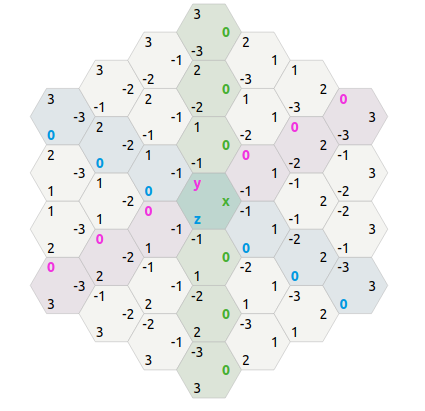

In [33]:
from IPython.display import Image
Image(filename='/home/bicepjai/Projects/mypuzzles/adventofcode/2017/images/hex_grid.png')

https://www.redblobgames.com/grids/hexagons/

### part 1

In [50]:
# hex grid directions in cube co ordinates (x,y,z)
dir_map = {"n" :(0,1,-1), "ne":(1,0,-1), "nw":(-1,1,0),
           "s" :(0,-1,1), "se":(1,-1,0), "sw":(-1,0,1)}
add_2cube_cord = lambda xyz1,xyz2:(xyz1[0]+xyz2[0],xyz1[1]+xyz2[1],xyz1[2]+xyz2[2])
distance_from_origin = lambda xyz: max(abs(xyz[0]), abs(xyz[1]), abs(xyz[2]))

def shortest_distance_to_hexgrid1(path):
    # starting at origin
    cco = (0,0,0) #current_co_ordinate
    for d in path:
        cco = add_2cube_cord(cco, dir_map[d])
    # shortest distance from origin
    return distance_from_origin(cco)

In [51]:
assert shortest_distance_to_hexgrid1(["ne","ne","ne"]) == 3
assert shortest_distance_to_hexgrid1(["ne","ne","sw","sw"]) == 0
assert shortest_distance_to_hexgrid1(["ne","ne","s","s"]) == 2
assert shortest_distance_to_hexgrid1(["se","sw","se","sw","sw"]) == 3

In [52]:
shortest_distance_to_hexgrid(input_data)

784

### part 2

In [53]:
def shortest_distance_to_hexgrid2(path):
    # starting at origin
    cco = (0,0,0) #current_co_ordinate
    max_distance = 0
    for d in path:
        cco = add_2cube_cord(cco, dir_map[d])
        max_distance = max(max_distance, distance_from_origin(cco))
    return max_distance

In [54]:
shortest_distance_to_hexgrid2(input_data)

1558

### for fun

In [55]:
def get_path_cords(path):
    # starting at origin
    path_cords = []
    cco = (0,0,0) #current_co_ordinate
    for d in path:
        path_cords += [cco]
        cco = add_2cube_cord(cco, dir_map[d])
    return path_cords

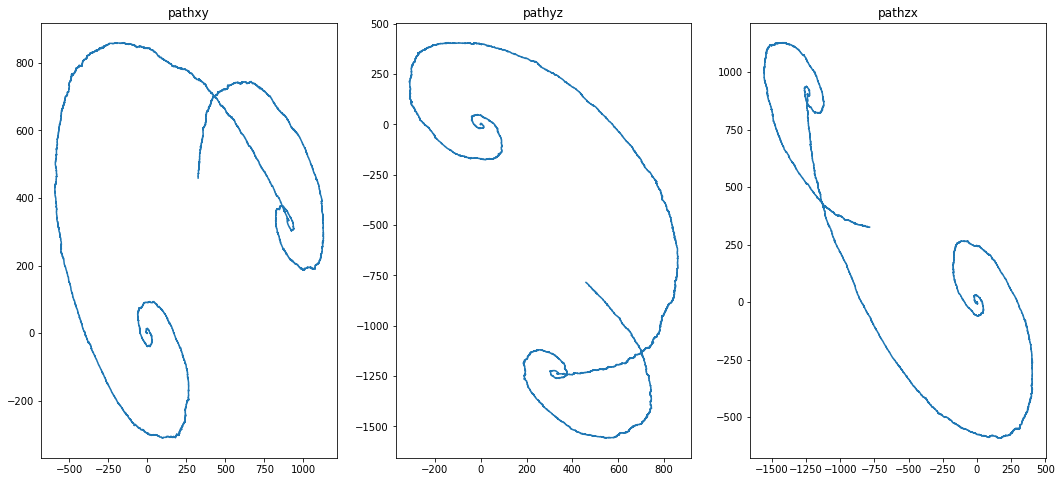

In [75]:
path_cords = get_path_cords(input_data)
fig,axes = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(18,8)

axes[0].set(title="pathxy")
axes[0].plot([t[0] for t in path_cords],[t[1] for t in path_cords])

axes[1].set(title="pathyz")
axes[1].plot([t[1] for t in path_cords],[t[2] for t in path_cords])

axes[2].set(title="pathzx")
axes[2].plot([t[2] for t in path_cords],[t[0] for t in path_cords])

plt.show()

## Day 12: Digital Plumber

In [76]:
! cat day12_input.txt

0 <-> 199, 1774
1 <-> 350, 1328, 1920
2 <-> 477, 984, 1419
3 <-> 1465, 1568
4 <-> 359, 1047, 1215, 1580, 1969
5 <-> 613
6 <-> 49, 617, 1213
7 <-> 1263
8 <-> 410
9 <-> 1224
10 <-> 1157
11 <-> 304, 1168, 1875
12 <-> 868, 891, 1369, 1712
13 <-> 958, 1371
14 <-> 1814
15 <-> 261, 556
16 <-> 830, 1646, 1901, 1933
17 <-> 962, 1778
18 <-> 109, 1229
19 <-> 239, 1070, 1886, 1930
20 <-> 327, 1307, 1801, 1905
21 <-> 943, 1950
22 <-> 1310
23 <-> 659, 917
24 <-> 373
25 <-> 369
26 <-> 947, 1023
27 <-> 338, 1901
28 <-> 1691
29 <-> 132, 1219, 1699, 1962
30 <-> 424, 822, 1419
31 <-> 1444, 1464
32 <-> 702, 1517
33 <-> 1639
34 <-> 909
35 <-> 690, 1655
36 <-> 988, 1149, 1166
37 <-> 649, 1300, 1441, 1699
38 <-> 1848
39 <-> 382
40 <-> 827, 1203, 1510
41 <-> 714, 1056, 1184
42 <-> 1018, 1873
43 <-> 214
44 <-> 670, 957
45 <-> 45
46 <-> 1195
47 <-> 559, 1504
48 <-> 1958
49 <-> 6
50 <-> 50, 1248
51 <-> 1151
52 <-> 52, 521, 1791
53 <-> 304
54 <-> 601
55 <-> 1328
56 <-> 939
57 <-> 1583, 1995
58 <-> 1422, 1694
59 <

forming adjaceny list as provided

In [244]:
input_data = {}
with open("day12_input.txt") as f:
    for line in f.read().strip().split("\n"):
        m = re.match(r"(\d+)\s*<->(.*)",line)
        input_data[int(m.group(1).strip())] = [int(n.strip()) for n in m.group(2).strip().split(",")]
len(input_data)

2000

In [245]:
def connected_componenets_dfs1(adj_list):
    # perform depth first search to count the components
    # connected to the node 0
    num_connected = 0
    visited = set()
    def helper_dfs(node):
        nonlocal num_connected, visited, adj_list
        if node not in visited:
            visited.add(node)
            num_connected += 1
            for child in adj_list[node]:
                helper_dfs(child)

    helper_dfs(0)
    return num_connected

def connected_componenets_dfs2(adj_list):
    # perform depth first search to count the components
    # connected to the node 0
    num_connected = 0
    visited = set()
    def helper_dfs(node):
        nonlocal num_connected, visited, adj_list
        visited.add(node)
        num_connected += 1
        for child in adj_list[node]:
            if child not in visited:
                helper_dfs(child)

    helper_dfs(0)
    return num_connected

In [246]:

def connected_componenets_bfs1(adj_list):
    # perform breadth first search to count the components
    # connected to the node 0
    num_connected = 0
    visited = set()
    q = [0] # enqueue->append dequeue->pop(0)
    while len(q) > 0:
        node = q.pop(0)
        if node not in visited:
            visited.add(node)
            num_connected += 1
            for child in adj_list[node]:
                q += [child]
        
    return num_connected

def connected_componenets_bfs2(adj_list):
    # perform breadth first search to count the components
    # connected to the node 0
    num_connected = 0
    visited = set()
    q = [0] # enqueue->append dequeue->pop(0)
    while len(q) > 0:
        node = q.pop(0)
        for child in adj_list[node]:
            if child not in visited:
                visited.add(child)
                num_connected += 1
                q += [child]
        
    return num_connected

In [247]:
sample_input="""0 <-> 2
1 <-> 1
2 <-> 0, 3, 4
3 <-> 2, 4
4 <-> 2, 3, 6
5 <-> 6
6 <-> 4, 5
"""
sample_data = {}
for line in sample_input.strip().split("\n"):
    m = re.match(r"(\d+)\s*<->(.*)",line)
    sample_data[int(m.group(1).strip())] = [int(n.strip()) for n in m.group(2).strip().split(",")]

In [248]:
assert connected_componenets_dfs1(sample_data) == connected_componenets_dfs2(sample_data)
assert connected_componenets_dfs1(sample_data) == connected_componenets_bfs1(sample_data)
assert connected_componenets_bfs1(sample_data) == connected_componenets_bfs2(sample_data)
assert connected_componenets_dfs1(sample_data) == connected_componenets_bfs2(sample_data)

In [250]:
assert connected_componenets_dfs1(input_data) == connected_componenets_dfs2(input_data)
assert connected_componenets_dfs1(input_data) == connected_componenets_bfs1(input_data)
assert connected_componenets_bfs1(input_data) == connected_componenets_bfs2(input_data)
assert connected_componenets_dfs1(input_data) == connected_componenets_bfs2(input_data)
connected_componenets_bfs2(input_data)

175

### part 2

In [159]:
def nof_connected_componenets_bfs(adj_list):
    num_groups = 0
    visited = set()
    
    # lets go thru all the nodes
    # and form connected compenents
    for root in adj_list:
        if root not in visited:
            num_groups += 1
        
        q = [root]
        while len(q) > 0:
            node = q.pop(0)
            if node not in visited:
                visited.add(node)
                for child in adj_list[node]:
                    q += [child]
                    
    return num_groups

In [161]:
assert nof_connected_componenets_bfs(sample_data) == 2

In [162]:
nof_connected_componenets_bfs(input_data)

213

## Day 13: Packet Scanners

In [163]:
! cat day13_input.txt

0: 4
1: 2
2: 3
4: 4
6: 6
8: 5
10: 6
12: 6
14: 6
16: 8
18: 8
20: 9
22: 12
24: 8
26: 8
28: 8
30: 12
32: 12
34: 8
36: 12
38: 10
40: 12
42: 12
44: 10
46: 12
48: 14
50: 12
52: 14
54: 14
56: 12
58: 14
60: 12
62: 14
64: 18
66: 14
68: 14
72: 14
76: 14
82: 14
86: 14
88: 18
90: 14
92: 17


In [3]:
input_data = {}
with open("day13_input.txt") as f:
    for line in f.read().strip().split("\n"):
        k,v = (p for p in line.split(":"))
        input_data[int(k)] = int(v)
len(input_data)

43

### part 1

Brute Force Solution where we are updating all the scanners as per the time step

In [208]:
def update_scanner_depths(scanner_pos,scanner_depths):
    for d in scanner_depths:
        scanner_pos[d][0] += scanner_pos[d][1]
        if (scanner_pos[d][0] == scanner_depths[d]-1 or scanner_pos[d][0] == 0):
            scanner_pos[d][1] *= -1

def scanner_severity_bf(scanner_depths):
    """
    given scanner depths find serverity
    """
    # dict holding the current depth and the inc/dec flag
    # once it reached bottom or top flag multiplies by -1, thus rotating
    scanner_pos = {k:[0,1] for k in scanner_depths.keys()}

    # since we always get caught first
    caughts = []

    # going thru each pico second thru each scanner
    # if scanner find us in place, we are not caught
    # cur_pos is same as current time
    total_time_range = max(scanner_depths.keys()) + 1
    for cur_time in range(total_time_range):        
        # when the cur_pos that indicates the
        # scanner caught us, its index will be top one i.e, 0
        if cur_time in scanner_depths.keys() and scanner_pos[cur_time][0] == 0:
            caughts += [(cur_time, scanner_depths[cur_time])]
            
        # update scanner depths
        update_scanner_depths(scanner_pos,scanner_depths)
        

    return sum([a*b for a,b in caughts])
    


one could notice that we are interested only in the 0th position not others, lets say the depth is 3.
the channel would be tracking as 

depth 3

time     0 1 2 3 4 5 6 7 8 9 

position 0 1 2 1 0 1 2 1 0 1

one could notice the 0s are always occuring at timesteps that are multiple of 4. 
can we generalize this pattern 

depth: 2

time     0 1 2 3 4 5 6 7 8 9 

position 0 1 0 1 0 1 0 1 0 1

depth: 4

time     0 1 2 3 4 5 6 7 8 9 

position 0 1 2 3 2 1 0 1 2 3

its (depth - 1)*2


In [209]:
def scanner_severity(scanner_depths):
    severity = 0
    # here sc_id is also time
    for sc_id_time, depth in scanner_depths.items():
        if sc_id_time % ((depth - 1)*2) == 0:
            severity += (sc_id_time * depth)
    return severity

In [212]:
sample_depths = {0:3, 1:2, 4:4, 6:4}
assert scanner_severity(sample_depths) == 24

In [213]:
scanner_severity(input_data)

1316

### part 2

In [215]:
def escaped_scanners_bf(scanner_depths):

    caught = True
    delay_time = 0
    while caught:
        
        # dict holding the current depth and the inc/dec flag
        # once it reached bottom or top flag multiplies by -1, thus rotating
        scanner_pos = {k:[0,1] for k in scanner_depths.keys()}
        caught = False
        
        # run for the delayed time
        for i in range(delay_time):
            update_scanner_depths(scanner_pos,scanner_depths)
        
        # go thru the scanners now
        total_time_range = max(scanner_depths.keys()) + 1
        for cur_time in range(total_time_range):        
            # when the cur_pos that indicates the
            # scanner caught us, its index will be top one i.e, 0
            # print("---b4  ",cur_time+10,scanner_pos)
            if cur_time in scanner_depths.keys() and scanner_pos[cur_time][0] == 0:
                # print("---caught---",cur_time,scanner_pos[cur_time])
                caught = True
                delay_time += 1
                break    
            # update scanner depths
            update_scanner_depths(scanner_pos,scanner_depths)
            # print("---aftr",cur_time+10,scanner_pos)
            
        # successfully ran thru without getting caught
        # print("=====================",delay_time)
        if not caught:
            break
        
    return delay_time

In [232]:
def escaped_scanners(scanner_depths):
    delay_time = 0
    caught = True
    while caught:
        caught = False
        for sc_id_time,depth in scanner_depths.items():
            if (sc_id_time + delay_time) % ((depth-1)*2) == 0:
                caught = True
                delay_time += 1
                break
        if not caught:
            break
    return delay_time

In [233]:
assert escaped_scanners_bf(sample_depths) == 10
assert escaped_scanners(sample_depths) == 10

In [234]:
escaped_scanners(input_data)

3840052

In [243]:
(1,1,"u")[:2]

(1, 1)

## Day 14: Disk Defragmentation

In [112]:
input_data = 'ffayrhll'
sample_data = 'flqrgnkx'

### part 1

In [114]:
bit_map = {
    0:0, 1:1, 2:1, 3:2,
    4:1, 5:2, 6:2, 7:3,
    8:1, 9:2, 10:2, 11:3,
    12:2, 13:3, 14:3, 15:4
}

def count_bits(hex_string):
    nof1s = 0
    # print("----",hex_string)
    for hex_ch in hex_string:
        nof1s += bit_map[int(hex_ch, 16)]
    return nof1s

In [121]:
def square_fragment_bits(data):
    fragment_bits = []
    for i in range(0,128):
        hash_str = data + "-" + str(i)
        fragment_bits += [knot_hash(hash_str)]
    return fragment_bits

def number_of_square_fragments(data):
    nofsquares = 0
    for hash_str in square_fragment_bits(data):
        nofsquares += sum(bin(int(ch, 16))[2:].count('1') for ch in hash_str)
    return nofsquares

In [122]:
number_of_square_fragments(sample_data) == 8108

True

In [123]:
number_of_square_fragments(input_data)

8190

### part 2

In [263]:
def mark_regions(data, r, c, region):
    if r > 127 or r < 0 or c > 127 or c < 0:
        return
    
    if data[r][c] == 1:
        # mark
        data[r][c] = region

        # recurse near by squares
        mark_regions(data, r+1, c, region)
        mark_regions(data, r-1, c, region)
        mark_regions(data, r, c-1, region)
        mark_regions(data, r, c+1, region)

def count_regions(data):
    fragment_bits = square_fragment_bits(data)
    
    bit_strings = []
    # lets make 128 x 128 bit strings
    for hash_str in fragment_bits:
        bit_string = bin(int(hash_str, 16))[2:]
        bit_string = "".join(['0']*(128-len(bit_string))) + bit_string
        bit_strings += [list(map(int,bit_string))]
        
    # go thru each square
    regions = 2
    for r in range(0,128):
        for c in range(0,128):
            if bit_strings[r][c] == 1:
                mark_regions(bit_strings, r, c, regions)
                regions += 1
    return regions - 2


In [264]:
sys.getrecursionlimit()

2000

In [265]:
count_regions(sample_data) == 1242

1242


True

In [266]:
count_regions(input_data)

1134


1134

## Day 15: Dueling Generators

input_data

Generator A starts with 512

Generator B starts with 191


In [3]:
gen_A_input = 512
gen_B_input = 191

gen_A_sample = 65
gen_B_sample = 8921


### part 1

In [26]:
def generatorA(input_value):
    current_value = input_value
    while True:
        current_value = (16807*current_value) % 2147483647
        yield current_value

def generatorB(input_value):
    current_value = input_value
    while True:
        current_value = (48271*current_value) % 2147483647
        yield current_value
    
def num_matches(gena_input, genb_input, rounds=int(4e7)):
    matches = 0
    gena_output = generatorA(gena_input)
    genb_output = generatorB(genb_input)
    bits16 = 0xFFFF
    for i in range(rounds):
        if next(gena_output)&bits16 == next(genb_output)&bits16:
            matches += 1
    return matches
        

In [28]:
num_matches(gen_A_sample, gen_B_sample, rounds=5) == 1
num_matches(gen_A_sample, gen_B_sample, rounds=int(4e7)) == 588

True

In [29]:
num_matches(gen_A_input, gen_B_input, rounds=int(4e7))

567

### part 2

In [30]:
def generatorA(input_value):
    current_value = input_value
    while True:
        current_value = (16807*current_value) % 2147483647
        if current_value % 4 == 0:
            yield current_value

def generatorB(input_value):
    current_value = input_value
    while True:
        current_value = (48271*current_value) % 2147483647
        if current_value % 8 == 0:
            yield current_value


In [32]:
num_matches(gen_A_sample, gen_B_sample, rounds=int(5e6)) == 309

True

In [33]:
num_matches(gen_A_input, gen_B_input, rounds=int(5e6))

323

## Day 16: Permutation Promenade

In [35]:
! cat day16_input.txt

x8/10,s15,x5/0,pd/a,x14/7,pg/l,s4,x0/12,s12,x2/1,s3,x11/6,pa/j,x9/2,pc/f,x8/12,s10,x3/1,s10,x13/15,pd/g,x6/11,s2,x12/14,s1,x7/5,s4,x10/11,pl/c,x12/1,s7,x3/8,s8,po/k,x1/14,s15,x11/7,pg/c,x2/12,pp/a,x3/1,s5,x13/8,s8,x12/7,s4,x4/6,s13,pf/h,x13/15,s1,x11/12,pc/l,x10/5,s12,x9/14,s2,x10/8,s13,x4/0,s6,x1/9,s7,pk/o,x2/4,pb/l,x15/0,s4,x7/13,ph/e,x10/12,s7,x7/0,s11,x15/5,s9,x1/3,s9,x0/4,s9,x11/3,pf/g,x14/5,pj/p,s13,x9/7,s7,x2/10,s15,x1/9,pd/o,x13/6,s4,x9/12,s15,x10/2,pp/n,x11/6,pm/a,s4,x13/7,s8,x15/2,s6,x5/12,s14,x4/2,s10,x0/13,s9,x9/5,s7,x11/7,pn/f,x5/6,pe/c,x3/2,s14,x6/11,s3,x3/15,s14,x6/14,s3,x4/12,s2,x14/15,s7,x13/5,pg/p,x15/6,s13,x3/10,s4,x14/11,po/l,x9/15,s14,x11/1,s1,x13/5,pa/e,x7/2,pb/i,x12/8,s2,ph/k,x5/2,pf/l,x7/9,s2,x2/4,s4,x15/1,s15,x2/9,s14,x0/1,s9,x10/2,s9,pn/p,x15/11,s5,x0/7,s12,x15/14,s4,pf/l,x3/1,s15,x11/8,pj/a,x9/3,pn/c,x0/7,pk/b,x15/13,pp/e,x4/8,s12,x0/9,pg/l,x14/15,s4,x5/13,pj/k,x10/2,s7,x8/5,pp/f,x12/7,po/b,x14/13,s5,x3/8,s1,x6/1,s10,x13/7,s9,x10/12,s13,x6/13,s12,x9/14,s5,x11

In [44]:
input_data = None
with open('day16_input.txt') as f:
    input_data = list(map(lambda s: (s[0],s[1:]) if s[0] == 's' else (s[0], tuple(s[1:].split('/'))), f.read().strip().split(",")))

### part 1

In [107]:
def one_dance_move(programs, command, params):
    if command == 's':
        index = int(params)
        programs = programs[-index:] + programs[:-index]
    elif command == 'x':
        i1,i2 = tuple(map(int, params))
        c1, c2 = programs[i1], programs[i2]
        programs = programs.replace(c1,'z')
        programs = programs.replace(c2,c1)
        programs = programs.replace('z',c2)
    elif command == 'p':
        c1,c2 = params
        programs = programs.replace(c1,'z')
        programs = programs.replace(c2,c1)
        programs = programs.replace('z',c2)
    return programs

def danceit1(data, programs=None, length=16):
    programs = "".join([chr(ord('a')+i) for i in range(length)]) if programs is None else programs
    for command, params in data:
        programs = one_dance_move(programs, command, params)
    return programs


In [108]:
danceit1([('s','1'),('x',('3','4')),('p',('e','b'))], length=5) == 'baedc'

True

In [109]:
danceit1(input_data, length=16)

'jkmflcgpdbonihea'

### part 2

In [121]:
def danceit2(data, length=16, rounds=int(1e9)):
    programs = "".join([chr(ord('a')+i) for i in range(length)])
    
    # lets find the cycle
    hash_map = {}
    prev_programs = programs
    cycle_round = None
    recycled_programs = None
    for r in range(rounds):
        programs = danceit1(input_data, prev_programs)
        if prev_programs in hash_map:
            cycle_round = r
            recycled_programs = prev_programs
            break
        hash_map[prev_programs] = programs
        prev_programs = programs
    
    # thru inspection we know its the same starting pattern
    # 'abcdefghijklmnop' occuring again, hence just harding coding this
    # if we need a general program, we need to process hash table to 
    # figure out the starting and the ending cycle and form the transformation as necessary
    programs = "".join([chr(ord('a')+i) for i in range(length)])
    for r in range(rounds%cycle_round):
        programs = danceit1(input_data, programs)
        
    print("----aftr",programs)
    return programs

In [122]:
danceit2(input_data)

----aftr ajcdefghpkblmion


'ajcdefghpkblmion'

## Day 17: Spinlock
